In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import logomaker

import glob
import re
from sklearn.decomposition import PCA

%matplotlib inline
plt.ion()

In [2]:
def extract_matrix(df, index, min_pos=None, max_pos=None):
    """
    Funciton to extract a matrix from a row of the dataframe
    """
    
    # Get list of all columns
    L = int(len([c for c in df.columns if '.' in c])/4)
    
    # Set min_pos
    if min_pos is None:
        min_pos = 0
        
    # Set max_pos
    if max_pos is None:
        max_pos = L
    
    # Create list of columns to extract
    cols = ['%02d.%s'%(i,c) for i in range(min_pos,max_pos) for c in 'ACGT']
    
    vec = df.loc[index,cols].values
    mat_arr = vec.reshape(-1,4)
    mat_df = pd.DataFrame(data=mat_arr, columns=list('ACGT'), dtype=float)
    return mat_df

In [3]:
# Load dataframe with all matrices
data_df = pd.read_csv('data.txt', delimiter='\t', index_col=0)
print('data_df has %d rows.'%len(data_df))
data_df.head()

data_df has 120 rows.


,lm,ars,mut,strain,exp,00.A,00.C,00.G,00.T,01.A,...,47.G,47.T,48.A,48.C,48.G,48.T,49.A,49.C,49.G,49.T
exp6_ars317_m3_IM,IM,ars317,F485I,m3,exp6,-0.004045,0.005569,-0.014642,0.013118,-0.008004,...,-0.079839,0.111333,-0.029961,0.035882,-0.035030,0.029108,0.013203,-0.013798,0.004710,-0.004115
exp7_ars317_m2_IM,IM,ars317,F485I,m2,exp7,-0.016780,-0.004333,-0.000826,0.021939,-0.001462,...,-0.078331,0.100685,-0.028536,0.038137,-0.043542,0.033941,0.020821,-0.014027,0.002652,-0.009445
exp6_ars317_m21_IM,IM,ars317,FY-AA,m21,exp6,0.005840,0.003235,-0.033633,0.024558,-0.011041,...,-0.099109,0.133206,-0.040175,0.055051,-0.039498,0.024623,0.008800,-0.006307,0.009684,-0.012177
exp7_ars317_m21_IM,IM,ars317,FY-AA,m21,exp7,0.007108,-0.002196,-0.022928,0.018016,-0.016403,...,-0.094059,0.133311,-0.035379,0.047618,-0.031899,0.019660,0.014209,-0.019739,0.018216,-0.012686
exp5_ars317_m22_IM,IM,ars317,FY-IQ,m22,exp5,-0.012484,0.023423,-0.027210,0.016271,-0.021774,...,-0.067821,0.124411,-0.000793,0.016263,-0.064366,0.048896,0.010426,-0.000222,-0.016731,0.006528


In [4]:
# Set data_cols and info_cols
data_cols = [c for c in data_df.columns if '.' in c]
info_cols = [c for c in data_df.columns if '.' not in c]
L = int(len(data_cols)/4)

# Just to be super sure, fix the gauge of each matrix in each row
print('Fixing gauges just to be sure')
for i, row in data_df.iterrows():
    vec = row[data_cols].values
    mat = vec.reshape(L,4)
    mat = mat - mat.mean(axis=1)[:,np.newaxis]
    mat /= (mat**2).sum()
    row[data_cols] = mat.ravel()
    print('.', end='')
print('\nDone.')

Fixing gauges just to be sure
........................................................................................................................
Done.


In [5]:
# Restrict strains to look at
strain_list = [
 'WT',
 'FY-YF',
 'F485I',
 'Y486Q',
 'FY-IQ',
 'FY-AA']
# strain_list = [
#  'WT',
#  'FY-YF',
#  'F485I',
#  'Y486Q',
#  'FY-IQ',
#  'FY-AA',
#  'N489A',
#  'N489W',
#  'R478A',
#  'R478K']

# Get default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Asign each strain a color
strain_to_color_dict = dict([(s, colors[n]) for n,s in enumerate(strain_list)])

# Set font size
fontsize=7
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)

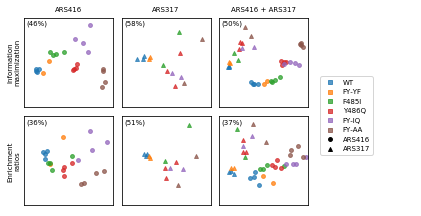

In [6]:
# Create figure
fig, axs = plt.subplots(2,4,figsize=[6,3])

# Set ars indices
ix_ars416 = data_df['ars'].str.match('ars416')\
            & data_df['mut'].isin(strain_list) \
            & data_df['exp'].isin(['exp4','exp7','exp9']) 

ix_ars317 = data_df['ars'].str.match('ars317')\
            & data_df['mut'].isin(strain_list) \
            & data_df['exp'].isin(['exp5','exp6','exp7']) \
            & ~((data_df['exp']=='exp5') & data_df['mut'].str.match('FY-IQ')) # This sample is bad
            
size=15
alpha=.75

# Panel rows correspond to lm
for row_num, lm in enumerate(['IM','ER']):
    
    # Create initial indices
    ix_row = data_df['lm'].str.match(lm)
    
    if lm=='IM':
        ylabel = 'Information\nmaximization'
    elif lm=='ER':
        ylabel = 'Enrichment\nratios'
    
    # Panel columns correspond to ars
    for col_num, ars in enumerate(['ars416','ars317','both']):
        
        # Set ax
        ax = axs[row_num, col_num]
        
        # Set indices and title
        if ars == 'ars416':
            ix = ix_row & ix_ars416
            title = f'ARS416'
        elif ars == 'ars317':
            ix = ix_row & ix_ars317
            title = f'ARS317'
        else:
            ix = ix_row & (ix_ars416 | ix_ars317)
            title = f'ARS416 + ARS317'
        
        # extract rows of dataframe 
        tmp_df = data_df[ix].copy()

        # Do PCA
        pca = PCA(n_components=2)
        X = tmp_df.loc[:,data_cols]
        pcs = pca.fit_transform(X)
        pca_cols = ['pc1','pc2']
        pca_df = pd.DataFrame(data=pcs, columns=pca_cols, index=tmp_df.index)
        pca_df = pd.concat([tmp_df[info_cols], pca_df], axis=1)
        
        # Compute pct variance explained
        pca_var = np.var(pcs, axis=0, ddof=0).sum()
        vec_var = np.var(X, axis=0, ddof=0).sum()
        pct_var_explained = 100*pca_var/vec_var

        # Dummy stuff for legend
        for strain in strain_list:
            color = strain_to_color_dict[strain]
            ax.scatter(x=[0], y=[0], color=color, label=strain, s=size, marker='s', alpha=alpha)
        ax.scatter(x=[0], y=[0], color='k', label='ARS416', s=size, marker='o')
        ax.scatter(x=[0], y=[0], color='k', label='ARS317', s=size, marker='^')
        ax.scatter(x=[0], y=[0], color='white', s=2*size, marker='s', alpha=1)
            
        # Plot strain by strain
        for i, strain in enumerate(strain_list):
            # Restrict df to chosen strain
            indices = (pca_df['mut']==strain) 
            tmp2_df = pca_df.loc[indices,:]

            xs = tmp2_df['pc1']
            ys = tmp2_df['pc2']
            ix = tmp2_df['ars']=='ars416'

            # Plot 416 points
            color = strain_to_color_dict[strain]
            if sum(ix) > 0:
                ax.scatter(x=xs[ix],y=ys[ix], 
                           color=color,
                           marker='o', s=size, alpha=alpha)

            # Plot 317 points
            if sum(~ix) > 0:
                ax.scatter(x=xs[~ix],y=ys[~ix], 
                           color=color,
                           marker='^', s=size, alpha=alpha)

        # Set lims
        xs = pca_df['pc1'].values
        ys = pca_df['pc2'].values
        rmax = max(np.sqrt(xs**2+ys**2))
        lims = np.array([-rmax, rmax])
        xlims = 1.05*lims
        ylims = 1.05*lims
        
        if col_num==0:
            ax.set_ylabel(ylabel)

        # Style plot
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')

        if row_num==0:
            ax.set_title(title)
        
        # Show pct variance explained
        x = xlims[0] + .03*(xlims[1]-xlims[0])
        y = ylims[1] - .03*(ylims[1]-ylims[0])
        ax.text(x=x, y=y, s='(%d%%)'%pct_var_explained, 
                horizontalalignment='left', 
                verticalalignment='top')        
    
axs[0,3].axis('off')
axs[1,3].axis('off')
plt.tight_layout(w_pad=-2)
axs[0,2].legend(loc='center left', ncol=1, bbox_to_anchor=(1.1,-.1))

plt.savefig('pca.pdf')

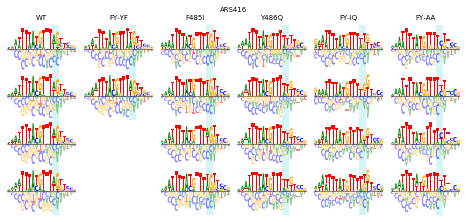

In [26]:
# Draw motifs from ARS416 
num_cols = len(strain_list)

fig, axs = plt.subplots(4,num_cols,figsize=[6.5,3])

# Set ars indices
ix_ars416 = data_df['ars'].str.match('ars416')\
            & data_df['mut'].isin(strain_list) \
            & data_df['exp'].isin(['exp4','exp7','exp9']) 

ylims = [-.3,.3]
        
for col_num, mut in enumerate(strain_list):
    
    # Extract rows from data_df
    ix = ix_ars416 & data_df['mut'].str.match(mut) & data_df['lm'].str.match('IM')
    tmp_df = data_df[ix]
    
    # Iterate over rows
    for row_num in range(axs.shape[0]):
        ax = axs[row_num, col_num]
        
        # Set title of column 
        if row_num==0:
            ax.set_title(f'{mut}')
        
        # Show logo if there is one
        if len(tmp_df) > row_num:
            name = tmp_df.index[row_num]
            mat_df = extract_matrix(tmp_df, name, min_pos=15, max_pos=35)
            logo = logomaker.Logo(df=mat_df, ax=ax, show_spines=False, fade_below=.5)
            ax.set_ylim(ylims)
            logo.highlight_position_range(pmin=13, pmax=14, color='paleturquoise', alpha=.5)
            ax.set_yticks([])
            ax.set_xticks([])
        else:
            ax.axis('off')
        
plt.tight_layout(h_pad=0)
fig.text(x=.5, y=1, s='ARS416', horizontalalignment='center', verticalalignment='top')
fig.savefig('logos_ars416.pdf')

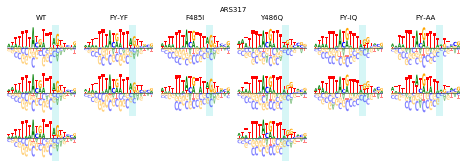

In [29]:
# Draw motifs from ARS317
num_cols = len(strain_list)
fig, axs = plt.subplots(3,num_cols,figsize=[6.5,2.25])

# Set ars indices
ix_ars317 = data_df['ars'].str.match('ars317')\
            & data_df['mut'].isin(strain_list) \
            & data_df['exp'].isin(['exp5','exp6','exp7']) \
            & ~((data_df['exp']=='exp5') & data_df['mut'].str.match('FY-IQ')) # This sample is bad

ylims = [-.35,.35]
            
for col_num, mut in enumerate(strain_list):
    
    # Extract rows from data_df
    ix = ix_ars317 & data_df['mut'].str.match(mut) & data_df['lm'].str.match('IM')
    tmp_df = data_df[ix]
    
    # Iterate over rows
    for row_num in range(axs.shape[0]):
        ax = axs[row_num, col_num]
        
        # Set title of column 
        if row_num==0:
            ax.set_title(f'{mut}')
        
        # Show logo if there is one
        if len(tmp_df) > row_num:
            name = tmp_df.index[row_num]
            mat_df = extract_matrix(tmp_df, name, min_pos=15, max_pos=35)
            logo = logomaker.Logo(df=mat_df, ax=ax, show_spines=False, fade_below=.5)
            ax.set_ylim(ylims)
            logo.highlight_position_range(pmin=13, pmax=14, color='paleturquoise', alpha=.5)
            ax.set_yticks([])
            ax.set_xticks([])
        else:
            ax.axis('off')
        
plt.tight_layout(h_pad=0)
fig.text(x=.5, y=1, s='ARS317', horizontalalignment='center', verticalalignment='top')
fig.savefig('logos_ars317.pdf')

In [9]:
# Comptue inter-cluster distance for IM v ER in ARS416
variance_df = pd.DataFrame(columns=['ars','strain','method','variance'])

for ars in ['ars416','ars317']:
    for i, strain in enumerate(strain_list):
        for lm in ['IM','ER']:

            # Restrict ix to chose ars
            if ars == 'ars416':
                ix = ix_ars416.copy()
            elif ars == 'ars317':
                ix = ix_ars317.copy()
            
            # Restrict to strain and lm
            ix &= data_df['mut'].str.match(strain) 
            ix &= data_df['lm'].str.match(lm)
            
            # Compute RMSD
            vecs = data_df.loc[ix,data_cols].values
            variance = np.var(vecs, axis=0, ddof=0).sum()
            
            # Record results in rmsd_df
            d = {'ars':ars, 'method':lm, 'strain':strain, 'variance':variance}
            variance_df = variance_df.append(d, ignore_index=True)

variance_df


,ars,strain,method,variance
0,ars416,WT,IM,0.017981
1,ars416,WT,ER,0.043846
2,ars416,FY-YF,IM,0.036526
3,ars416,FY-YF,ER,0.067726
4,ars416,F485I,IM,0.029351
5,ars416,F485I,ER,0.050340
6,ars416,Y486Q,IM,0.018796
7,ars416,Y486Q,ER,0.045296
8,ars416,FY-IQ,IM,0.104923
9,ars416,FY-IQ,ER,0.153982


In [36]:
# Compute pct reduction in RMSD
for ars in ['ars416','ars317']:
    tmp_df = variance_df[variance_df['ars']==ars].copy()
    tmp_df = tmp_df[['strain','method','variance']]
    tmp_df = tmp_df.pivot(index='strain', columns='method')
    tmp_df.columns = ['ER','IM']
    tmp_df['IM/ER'] = tmp_df['IM']/tmp_df['ER']
    pct_reduction =  100*(1-tmp_df['IM/ER'].mean())
    print(f'{ars}: {pct_reduction} pct reduction in variance from ER to IM')

ars416: 46.61926748436932 pct reduction in variance from ER to IM
ars317: 38.519355243190034 pct reduction in variance from ER to IM


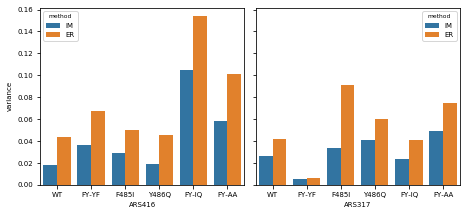

In [11]:
import seaborn as sns
fig, axs = plt.subplots(1,2,figsize=[6.5,3], sharey=True)

for i, ars in enumerate(['ars416','ars317']):
    ix = variance_df['ars']==ars
    ax = axs[i]
    sns.barplot(data=variance_df[ix], x='strain', hue='method', y='variance', ax=ax)
    title_dict = {'ars416':'ARS416', 'ars317':'ARS317'}
    if i==1:
        ax.set_ylabel('')
    ax.set_xlabel(title_dict[ars])
    
plt.tight_layout()
fig.savefig('variance.pdf')